In [10]:
import gwpy
from gwpy.timeseries import TimeSeries
import pandas as pd
import h5py
import numpy as np
import os
from astropy.utils.data import clear_download_cache
import pycbc
#from pycbc.types.timeseries import TimeSeries
from pycbc.psd import interpolate

# Define a function to download data and return as an array
def download_gw_data(gps_time):
    try:
        start_time = gps_time - 8  # 0.5 seconds before the event
        end_time = gps_time + 8    # 0.5 seconds after the event
        data = TimeSeries.fetch_open_data('L1', start_time, end_time, cache=True)
        return data
    except ValueError as e:
        print(f"Data not available for GPS time {gps_time}: {e}")

        # Clear the Astropy download cache
        clear_download_cache()
        
        return None

# Read the GPS times and SNR from the CSV file (first 100 entries)
file_path = 'Glitch_data/gspy_low_freq_burst.csv'  # Replace with your file path
glitches = pd.read_csv(file_path).head(100)

# Lists to store strain data arrays and SNRs
strains = []
snrs = []

# Loop through the first 100 GPS times and download data
for index, row in glitches.iterrows():
    gps_time = row['GPStime']  # Replace 'GPStime' if your column name is different
    snr = row['snr']          # Replace 'snr' if your column name is different
    strain_data = download_gw_data(gps_time)
    if strain_data is not None:
        # Downsampling by taking every second data point
#        downsampled_strain = strain_data[::2]
        
        # Whiten data
#        downsampled_strain = downsampled_strain.whiten(4,2)

        # Crop data to 1 sec
#        downsampled_strain = downsampled_strain.crop(gps_time - 0.8, gps_time + 0.2)


        data = pycbc.types.timeseries.TimeSeries(strain_data.value[::2], delta_t=1.0 / 2048, epoch=strain_data.times[0].value)

        data, psd_pycbc = data.whiten(segment_duration=4,
                                   max_filter_duration=4,
                                   remove_corrupted=True, return_psd=True)

        # Apply a high-pass to remove everything below `bandpass_lower`
        data  = data.highpass_fir(frequency=30,remove_corrupted=True,
                                             order=512)

        data = data.time_slice(gps_time - 0.80, gps_time + 0.20)

#        strains.append(downsampled_strain.value)
#        snrs.append(snr)
        
        data_array = data.numpy()
        # Check if data_array does not contain any NaNs
        if not np.isnan(data_array).any():
            strains.append(data_array)
            snrs.append(snr)
        
        #strains.append(data.numpy())
        #snrs.append(snr)
max_length = max(len(arr) for arr in strains)  # Find the length of the longest array
padded_arrays = [np.pad(arr, (0, max_length - len(arr)), 'constant', constant_values=0) for arr in strains]

combined_strains = np.array(padded_arrays)


# Combine all strain data into a single array
#combined_strains = np.array(strains)
combined_snrs = np.array(snrs)

# Folder to save the combined HDF5 file
output_folder = 'Glitch_data'

# Check if folder exists, if not create it
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Save the combined strains and SNRs to an HDF5 file in the 'Blip' folder
output_file_path = os.path.join(output_folder, 'combined_strains_snr_low_freq_burst_whitened_1.hdf5')
with h5py.File(output_file_path, 'w') as f:
    f.create_dataset('Strain', data=combined_strains)
    f.create_dataset('SNR', data=combined_snrs)

print(f"Combined strain and SNR data written to {output_file_path}")
f.close()


Data not available for GPS time 1236756591.805: Cannot find a GWOSC dataset for L1 covering [1236756583, 1236756600)
Data not available for GPS time 1387110427.938: Cannot find a GWOSC dataset for L1 covering [1387110419, 1387110436)
Data not available for GPS time 1386904789.688: Cannot find a GWOSC dataset for L1 covering [1386904781, 1386904798)
Data not available for GPS time 1371562982.906: Cannot find a GWOSC dataset for L1 covering [1371562974, 1371562991)
Data not available for GPS time 1380031693.781: Cannot find a GWOSC dataset for L1 covering [1380031685, 1380031702)
Data not available for GPS time 1377258108.594: Cannot find a GWOSC dataset for L1 covering [1377258100, 1377258117)
Data not available for GPS time 1380407344.031: Cannot find a GWOSC dataset for L1 covering [1380407336, 1380407353)
Data not available for GPS time 1382368687.719: Cannot find a GWOSC dataset for L1 covering [1382368679, 1382368696)
Data not available for GPS time 1382938096.094: Cannot find a GW

In [18]:
f.close()

In [2]:
from astropy.utils.data import clear_download_cache

# Clear the Astropy download cache
clear_download_cache()

print("Astropy cache has been cleared.")


Astropy cache has been cleared.


In [4]:
import h5py

f1 = h5py.File('Glitch_data/combined_strains_snr_whistle_whitened_1.hdf5', 'r')

f1['Strain'][()].shape

(78, 2049)

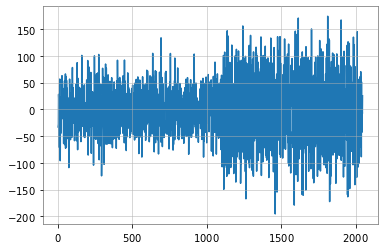

In [4]:
from matplotlib import pyplot as plt

plt.plot(f1['Strain'][0])

In [20]:
# Read the GPS times and SNR from the CSV file (first 50 entries)
file_path = 'gspy_blip.csv'  # Replace with your file path
glitches = pd.read_csv(file_path).head(200)

# Lists to store strain data arrays and SNRs
strains = []
snrs = []
gps_times = []

# Loop through the first 50 GPS times and download data
for index, row in glitches.iterrows():
    gps_times.append(row['GPStime'])  # Replace 'GPStime' if your column name is different
    snr = row['snr']          # Replace 'snr' if your column name is different
